In [1]:
%matplotlib notebook

import cv2, matplotlib
import numpy as np

from math import sqrt

import matplotlib.pyplot as plt

from os.path import expanduser, splitext
from os import scandir, makedirs

# import random

import csv

from tqdm import tnrange, tqdm_notebook

from pathlib import Path

debug = False  # plot every steps

In [2]:
def read_from_csv(filepath):
    if Path(filepath).is_file():

        with open(filepath, "r", newline="", encoding="utf-8-sig") as csvfile:
            listreader = csv.reader(csvfile)
            columns = next(listreader)
            readlist = list(listreader)

    else:
        columns = []
        readlist = []

    return columns, readlist


def read_bgr_from_image_unicode(path):
    """workaround for non-ascii filenames"""

    stream = open(path, "rb")
    bytes = bytearray(stream.read())
    numpyarray = np.asarray(bytes, dtype=np.uint8)
    bgr = cv2.imdecode(numpyarray, cv2.IMREAD_UNCHANGED)

    return bgr


def save_bgr_to_image_unicode(bgr, path, ext_to=".png"):
    """workaround for non-ascii filenames"""

    _, numpyarray = cv2.imencode(ext_to, bgr)
    with open(path, "wb") as file:
        file.write(numpyarray)

# unit mask

In [3]:
def color_dict_mask(
    img_dict={
        "Lab": np.zeros((1, 1, 3), dtype="uint8"),
        "HSV": np.zeros((1, 1, 3), dtype="uint8"),
    },
    colors={
        "colorname": {
            "Lab": ([0, 0, 0], [255, 255, 255]),
            "HSV": ([0, 0, 0], [255, 255, 255]),
        }
    },
):
    # get masks matching any of the colors matching all descriptions

    mask = np.zeros_like(list(img_dict.values())[0][:, :, 0])
    for color_dict in colors.values():
        mask_color = np.ones_like(mask) * 255
        for colorspace, limits in color_dict.items():
            mask_colorspace = cv2.inRange(
                img_dict[colorspace], np.array(limits[0]), np.array(limits[1])
            )
            mask_color = cv2.bitwise_and(mask_color, mask_colorspace)

        mask = cv2.bitwise_or(mask, mask_color)

    return mask


def get_color_mask(
    bgr=np.zeros((1, 1, 3), dtype="uint8"),
    colors={
        "colorname": {
            "Lab": ([0, 0, 0], [255, 255, 255]),
            "HSV": ([0, 0, 0], [255, 255, 255]),
        }
    },
):
    lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2Lab)

    blur = {}
    blur["Lab"] = cv2.bilateralFilter(lab, 15, 25, 150)
    blur["BGR"] = cv2.cvtColor(blur["Lab"], cv2.COLOR_Lab2BGR)
    blur["HSV"] = cv2.cvtColor(blur["BGR"], cv2.COLOR_BGR2HSV)

    # get masks matching any of the colors matching all descriptions

    mask = color_dict_mask(blur, colors)

    # fill holes and remove noise

    contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

    holes = [contours[i] for i in range(len(contours)) if hierarchy[0][i][3] >= 0]
    cv2.drawContours(mask, holes, -1, 255, -1)

    kernel_5c = np.array(
        [
            [0, 1, 1, 1, 0],
            [1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1],
            [0, 1, 1, 1, 0],
        ],
        dtype=np.uint8,
    )

    kernel_9c = np.zeros((9, 9), np.uint8)
    cv2.circle(kernel_9c, (4, 4), 4, 1, -1)

    kernel_15c = np.zeros((15, 15), np.uint8)
    cv2.circle(kernel_15c, (7, 7), 7, 1, -1)

    # mask = cv2.erode(mask, kernel_5c, iterations=1)

    smallbits = [
        contours[i]
        for i in range(len(contours))
        if hierarchy[0][i][3] == -1 and cv2.contourArea(contours[i]) <= 100
    ]
    cv2.drawContours(mask, smallbits, -1, 0, -1)

    # removing imperfections

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    for c in contours:
        if cv2.contourArea(c) >= 100:
            mask_single_c = np.zeros_like(mask)
            cv2.drawContours(mask_single_c, c, -1, 255, -1)

            mask_single_c = cv2.morphologyEx(
                mask_single_c, cv2.MORPH_CLOSE, kernel_9c, iterations=1
            )
            mask |= mask_single_c

    return mask


def get_marked_contours(contours, marker_mask, min_marked_area):
    marked_contours = []

    for c in contours:
        mask_single_c = np.zeros_like(marker_mask)
        cv2.drawContours(mask_single_c, [c], -1, 255, -1)

        c_area = cv2.countNonZero(mask_single_c)
        marked_area = cv2.countNonZero(mask_single_c & marker_mask)

        if marked_area >= min_marked_area:
            marked_contours.append(c)

    return marked_contours


def get_marked_mask(boundary_mask, marker_mask, min_marked_area):
    contours, hierarchy = cv2.findContours(
        boundary_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE
    )

    marked_contours = get_marked_contours(contours, marker_mask, min_marked_area)

    marked_mask = np.zeros_like(boundary_mask)

    if marked_contours:
        cv2.drawContours(marked_mask, marked_contours, -1, 255, -1)

    return marked_mask


def get_wall_mask(bgr=np.zeros((1, 1, 3), dtype="uint8")):

    kernel_3 = np.ones((3, 3), np.uint8)
    kernel_5c = np.array(
        [
            [0, 1, 1, 1, 0],
            [1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1],
            [0, 1, 1, 1, 0],
        ],
        dtype=np.uint8,
    )

    # get mask based on color and shape

    redimg = bgr[:, :, 2]
    _, threshold_img_inv = cv2.threshold(redimg, 140, 255, cv2.THRESH_BINARY_INV)
    #     plt.imshow(threshold_img_inv)

    threshold_blur = cv2.medianBlur(threshold_img_inv, 5)
    #     plt.imshow(threshold_blur)
    erosion = cv2.erode(threshold_blur, kernel_3)
    opening = cv2.morphologyEx(threshold_blur, cv2.MORPH_OPEN, kernel_3)
    #     dilation = cv2.dilate(opening, kernel_3)
    #     plt.imshow(opening)
    mask = cv2.bitwise_and(threshold_img_inv, opening)
    #     plt.figure()
    #     plt.imshow(mask)

    kernel = kernel_5c

    ret, markers = cv2.connectedComponents(mask)
    #     plt.figure()
    #     plt.imshow(markers)

    wall_mask = np.zeros_like(mask)
    for i in range(1, ret):
        if (markers == i).sum() > 300:
            wall_mask |= (markers == i).astype(np.uint8) * 255
    #     plt.figure()
    #     plt.imshow(wall_mask)

    return wall_mask


def get_LDK_mask(bgr=np.zeros((1, 1, 3), dtype="uint8")):
    floor_colors = {
        "floor_light": {
            "Lab": ([180, 130, 160], [220, 150, 190]),
            "HSV": ([0, 65, 180], [20, 255, 255]),
        },
        "floor_dark": {
            "Lab": ([120, 130, 150], [180, 155, 190]),
            "HSV": ([0, 90, 100], [20, 255, 230]),
        },
        "floor_watermark": {
            "Lab": ([220, 125, 145], [240, 145, 165]),
            "HSV": ([0, 65, 220], [20, 255, 255]),
        },
    }

    mask = get_color_mask(bgr, floor_colors)

    return mask


def get_bedroom_mask(bgr=np.zeros((1, 1, 3), dtype="uint8")):
    bedroom_boundary = {
        "bedroom_boundary": {
            "Lab": ([180, 120, 132], [254, 135, 165]),
            "HSV": ([10, 25, 200], [30, 110, 255]),
        }
    }
    bedroom_dark = {
        "bedroom_dark": {
            "Lab": ([160, 124, 139], [250, 130, 165]),
            "HSV": ([10, 30, 200], [30, 90, 250]),
        }
    }
    balcony_colors = {"balcony": {"Lab": ([240, 125, 130], [254, 135, 140])}}

    bedroom_boundary_mask = get_color_mask(bgr, bedroom_boundary)
    bedroom_dark_mask = get_color_mask(bgr, bedroom_dark)
    balcony_mask = get_color_mask(bgr, balcony_colors)

    # remove balconies which is similarily colored

    mask_bedroom_only = np.zeros_like(bedroom_boundary_mask)

    contours, _ = cv2.findContours(
        bedroom_boundary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE
    )

    for c in contours:
        mask_single_c = np.zeros_like(mask_bedroom_only)
        cv2.drawContours(mask_single_c, [c], -1, 255, -1)

        c_area = cv2.countNonZero(mask_single_c)
        dark_area = cv2.countNonZero(mask_single_c & bedroom_dark_mask)
        balcony_area = cv2.countNonZero(mask_single_c & balcony_mask)

        if dark_area >= 1000:
            mask_bedroom_only |= mask_single_c
    return mask_bedroom_only


def get_balcony_mask(bgr=np.zeros((1, 1, 3), dtype="uint8")):
    balcony_boundary = {
        "bedroom_boundary": {
            "Lab": ([180, 120, 132], [254, 135, 165]),
            "HSV": ([10, 15, 200], [30, 110, 255]),
        }
    }
    bedroom_dark = {
        "bedroom_dark": {
            "Lab": ([160, 124, 139], [250, 130, 165]),
            "HSV": ([10, 30, 200], [30, 90, 250]),
        }
    }
    balcony_colors = {"balcony": {"Lab": ([240, 125, 130], [254, 135, 140])}}

    balcony_boundary_mask = get_color_mask(bgr, balcony_boundary)
    bedroom_dark_mask = get_color_mask(bgr, bedroom_dark)
    balcony_mask = get_color_mask(bgr, balcony_colors)

    # remain balconies only

    mask_balcony_only = np.zeros_like(balcony_boundary_mask)

    contours, _ = cv2.findContours(
        balcony_boundary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE
    )

    for c in contours:
        mask_single_c = np.zeros_like(mask_balcony_only)
        cv2.drawContours(mask_single_c, [c], -1, 255, -1)

        c_area = cv2.countNonZero(mask_single_c)
        dark_area = cv2.countNonZero(mask_single_c & bedroom_dark_mask)
        balcony_area = cv2.countNonZero(mask_single_c & balcony_mask)

        if dark_area <= 10 <= balcony_area:
            mask_balcony_only |= mask_single_c
    return mask_balcony_only


def get_entrance_mask(bgr=np.zeros((1, 1, 3), dtype="uint8")):
    entrance_boundary = {"white_and_gray": {"HSV": ([0, 0, 170], [255, 20, 255])}}
    white = {"white": {"HSV": ([0, 0, 245], [255, 10, 255])}}
    gray = {"gray": {"HSV": ([0, 0, 230], [255, 10, 245])}}

    lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2Lab)

    blur = {}
    blur["Lab"] = cv2.bilateralFilter(lab, 15, 5, 150)
    blur["BGR"] = cv2.cvtColor(blur["Lab"], cv2.COLOR_Lab2BGR)
    blur["HSV"] = cv2.cvtColor(blur["BGR"], cv2.COLOR_BGR2HSV)

    kernel_3 = np.ones((3, 3), np.uint8)
    kernel_5c = np.array(
        [
            [0, 1, 1, 1, 0],
            [1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1],
            [0, 1, 1, 1, 0],
        ],
        dtype=np.uint8,
    )
    kernel_7c = np.zeros((7, 7), np.uint8)
    cv2.circle(kernel_7c, (3, 3), 3, 1, -1)
    kernel_9c = np.zeros((9, 9), np.uint8)
    cv2.circle(kernel_9c, (4, 4), 4, 1, -1)
    kernel_15c = np.zeros((15, 15), np.uint8)
    cv2.circle(kernel_15c, (7, 7), 7, 1, -1)

    mask_e, mask_w, mask_g = [
        color_dict_mask(blur, x) for x in [entrance_boundary, white, gray]
    ]
    area_e, area_w, area_g = [cv2.countNonZero(x) for x in [mask_e, mask_w, mask_g]]

    mask_e_e = cv2.erode(mask_e, kernel_7c)

    mask_w_d, mask_g_d = [cv2.dilate(x, kernel_15c) for x in [mask_w, mask_g]]
    mask_wg_c = cv2.erode(mask_w_d & mask_g_d, kernel_15c)

    if debug:
        print(area_e, area_w, area_g)
        plt.figure()
        plt.imshow(mask_e_e & 32 | mask_wg_c & 128)

    contours, hierarchy = cv2.findContours(
        mask_e_e & mask_wg_c, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE
    )

    mask_ent = np.zeros_like(mask_e)

    for i in range(len(contours)):
        if hierarchy[0][i][3] == -1:
            cnt = contours[i]
            mask_c = np.zeros_like(mask_ent)
            cv2.drawContours(mask_c, [cnt], -1, 255, -1)

            area_c = cv2.countNonZero(mask_c & mask_e)
            area_c_w = cv2.countNonZero(mask_c & mask_w)
            area_c_g = cv2.countNonZero(mask_c & mask_g)

            if (
                area_c >= 100
                and area_c >= 0.01 * area_g
                and area_c_w >= 0.3 * area_c
                and area_c_g >= 0.3 * area_c
                and area_c_w + area_c_g >= 0.8 * area_c
            ):
                mask_ent |= mask_c

    mask_ent = cv2.morphologyEx(mask_ent, cv2.MORPH_CLOSE, kernel_15c)

    if debug:
        plt.figure()
        plt.imshow(mask_g & 32 | mask_ent & 128)

    return mask_ent


def get_bathroom_mask(bgr=np.zeros((1, 1, 3), dtype="uint8")):
    bathroom_colors = {"bathroom": {"HSV": ([90, 10, 220], [110, 40, 255])}}

    mask = get_color_mask(bgr, bathroom_colors)

    return mask


def get_watershed(
    thresh=np.zeros((1, 1), dtype="uint8"), markers=np.zeros((1, 1), dtype="uint8")
):
    unknown = cv2.subtract(thresh, markers.astype(thresh.dtype))

    markers = markers.astype(np.int32)
    markers = markers + 1
    markers[unknown == 255] = 0

    markers = cv2.watershed(np.stack([thresh] * 3, axis=2), markers)
    markers = markers - 1
    markers[markers <= 0] = 0

    return markers

In [4]:
def get_unit_mask(bgr=np.zeros((1, 1, 3), dtype="uint8")):
    """Returns unit plan masks of the unit plan, 
    as a dictionary of opencv masks and also a single combined mask,
    including masks for walls, entrances, LDK, bedrooms, balconies, and bathrooms."""

    AREA_UNIT = 128
    AREA_WALL = 64
    AREA_ENTRANCE = 32
    AREA_LDK = 16
    AREA_BEDROOM = 8
    AREA_BALCONY = 4
    AREA_BATHROOM = 2

    kernel_3 = np.ones((3, 3), np.uint8)
    kernel_5c = np.array(
        [
            [0, 1, 1, 1, 0],
            [1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1],
            [1, 1, 1, 1, 1],
            [0, 1, 1, 1, 0],
        ],
        dtype=np.uint8,
    )
    kernel_7c = np.zeros((7, 7), np.uint8)
    cv2.circle(kernel_7c, (3, 3), 3, 1, -1)
    kernel_9c = np.zeros((9, 9), np.uint8)
    cv2.circle(kernel_9c, (4, 4), 4, 1, -1)
    kernel_15c = np.zeros((15, 15), np.uint8)
    cv2.circle(kernel_15c, (7, 7), 7, 1, -1)

    lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2Lab)
    blur = {}
    blur["Lab"] = cv2.bilateralFilter(lab, 15, 25, 150)
    blur["BGR"] = cv2.cvtColor(blur["Lab"], cv2.COLOR_Lab2BGR)
    blur["HSV"] = cv2.cvtColor(blur["BGR"], cv2.COLOR_BGR2HSV)

    ######################################
    # Get wall/indoor/outdoor markers    #
    ######################################

    ### get wall

    wall_mask = get_wall_mask(bgr)
    wall_mask_d = cv2.dilate(wall_mask, kernel_9c)

    ### indoor without gray parts

    not_gray = {"not_gray": {"HSV": ([0, 10, 120], [255, 255, 254])}}
    indoor_mask = get_color_mask(bgr, not_gray)

    # entrance
    ent_mask = get_entrance_mask(bgr)

    indoor_mask |= ent_mask

    ### outside of the largest foreground area as outdoor boundary

    white_color = {"white": {"HSV": ([0, 0, 245], [255, 10, 255])}}
    white_mask = color_dict_mask({"HSV": blur["HSV"]}, white_color)

    ret, markers = cv2.connectedComponents(~white_mask)
    max_i = max(range(1, ret), key=lambda i: (markers == i).sum())
    #     print(max_i)
    mask = (markers == max_i).astype(np.uint8) * 255
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel_15c)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    cv2.drawContours(mask, contours, -1, 255, -1)

    outdoor_mask = cv2.morphologyEx(~mask, cv2.MORPH_CLOSE, kernel_9c)
    indoor_mask &= mask

    ### leave zones containing indoor marker only

    outdoor_mask_d = cv2.dilate(outdoor_mask, kernel_9c)
    zones = ~outdoor_mask_d & ~wall_mask_d
    zones = cv2.dilate(zones, kernel_9c)

    ret, markers = cv2.connectedComponents(zones)
    for i in range(1, ret):
        marker = (markers == i).astype(np.uint8) * 255
        if not (marker & indoor_mask).sum() and (marker & outdoor_mask_d).sum():
            outdoor_mask |= marker

    outdoor_mask = cv2.morphologyEx(outdoor_mask, cv2.MORPH_CLOSE, kernel_9c)

    ### get black borders other than walls

    black = {
        "black": {"HSV": ([0, 0, 0], [255, 255, 100])},
        "dark_gray": {"HSV": ([0, 0, 0], [255, 20, 160])},
    }
    black_mask = color_dict_mask({"HSV": blur["HSV"]}, black)
    black_border = black_mask & ~wall_mask_d & ~outdoor_mask_d
    black_border_d = cv2.dilate(black_border, kernel_5c)

    # remove black borders not touching walls
    black_border_wall = np.zeros_like(black_border)
    ret, markers = cv2.connectedComponents(black_border_d)
    for i in range(1, ret):
        marker = (markers == i).astype(np.uint8) * 255
        if cv2.connectedComponents(marker & wall_mask_d)[0] >= 2:
            black_border_wall |= marker

    if debug:
        plt.figure()
        plt.imshow(
            wall_mask_d & 128
            | black_border_wall & 64
            | indoor_mask & 32
            | outdoor_mask & 16
        )

    ######################################
    # classify zones inbetween in/out    #
    ######################################

    # core is big and detached from indoor
    # how big
    core_limit = max(10000, 0.1 * cv2.countNonZero(indoor_mask))

    # 1st round: in-between areas as a whole
    indoor_mask_d = cv2.dilate(indoor_mask, kernel_9c)
    outdoor_mask_d = cv2.dilate(outdoor_mask, kernel_9c)

    zones = ~(indoor_mask_d | outdoor_mask_d | wall_mask_d)
    zones = cv2.dilate(zones, kernel_9c)
    ret, markers = cv2.connectedComponents(zones)
    if debug:
        print(ret)

    indoor_touching_zones = markers.astype(np.uint16) & (
        (np.ones_like(markers) & indoor_mask_d.astype(np.uint16)) * 65535
    )
    indoor_touching_zone_numbers = list(np.nditer(np.unique(indoor_touching_zones)))
    indoor_touching_zone_numbers.remove(0)

    for i in indoor_touching_zone_numbers:
        marker = (markers == i).astype(np.uint8) * 255
        if (
            cv2.countNonZero(marker) < core_limit
            and cv2.countNonZero(marker & outdoor_mask) == 0
        ):
            indoor_mask |= marker

    # 2nd round: individual zones divided by black borders
    zones = ~(wall_mask_d | black_border_wall)
    ret, markers = cv2.connectedComponents(zones)
    markers = markers.astype(np.uint16)
    markers = cv2.dilate(markers, kernel_3)
    if debug:
        print(ret)
        plt.figure()
        plt.imshow(markers)

    more = True
    while more:
        more = False

        # get indoor touching zones
        indoor_mask_d = cv2.dilate(indoor_mask, kernel_9c)
        indoor_mask_boundary = indoor_mask_d & ~indoor_mask
        indoor_touching_zones = markers & (
            (np.ones_like(markers) & indoor_mask_boundary.astype(np.uint16)) * 65535
        )
        indoor_touching_zone_numbers = list(np.nditer(np.unique(indoor_touching_zones)))
        indoor_touching_zone_numbers.remove(0)
        for i in indoor_touching_zone_numbers:
            marker = (markers == i).astype(np.uint8) * 255
            if (
                (
                    cv2.countNonZero(marker)
                    - (cv2.countNonZero(marker & indoor_mask_d) ** 2) * 0.1
                )
                < core_limit * 0.1
            ) and (cv2.countNonZero(marker & outdoor_mask) == 0):
                indoor_mask |= marker
                more = True
            else:
                outdoor_mask |= marker

        if debug and more:
            print(".", end="")

    if debug:
        plt.figure()
        plt.imshow(wall_mask_d & 128 | indoor_mask & 32 | outdoor_mask & 16)

    unit_mask = indoor_mask_d

    #####################################
    # Getting color based masks         #
    #####################################

    wall_mask_d &= unit_mask
    ent_mask &= unit_mask

    ldk_mask = get_LDK_mask(bgr) & unit_mask
    bed_mask = get_bedroom_mask(bgr) & unit_mask
    bal_mask = get_balcony_mask(bgr) & unit_mask

    bath_mask = get_bathroom_mask(bgr) & unit_mask

    #####################################
    # Combine all markers in uint8      #
    #####################################

    area_pairs = [
        (unit_mask, AREA_UNIT),
        (wall_mask_d, AREA_WALL),
        (ent_mask, AREA_ENTRANCE),
        (ldk_mask, AREA_LDK),
        (bed_mask, AREA_BEDROOM),
        (bal_mask, AREA_BALCONY),
        (bath_mask, AREA_BATHROOM),
    ]

    area_markers = np.zeros_like(wall_mask)
    for area_mask, area_bit in area_pairs:
        area_markers |= area_mask & area_bit

    if debug:
        plt.figure()
        plt.imshow(area_markers)

    #####################################
    # Pack the return masks             #
    #####################################

    combined_mask = area_markers.astype(np.uint8)

    unit_mask_dict = {
        "unit": unit_mask,
        "wall": wall_mask_d,
        "entrance": ent_mask,
        "LDK": ldk_mask,
        "bedroom": bed_mask,
        "balcony": bal_mask,
        "bathroom": bath_mask,
    }

    return unit_mask_dict, combined_mask

# test and vis

In [5]:
cv2.__version__

'4.1.0'

In [21]:
bgr = read_bgr_from_image_unicode("/fp_img/9765_107A.jpg")
# plt.imshow(bgr)

<IPython.core.display.Javascript object>


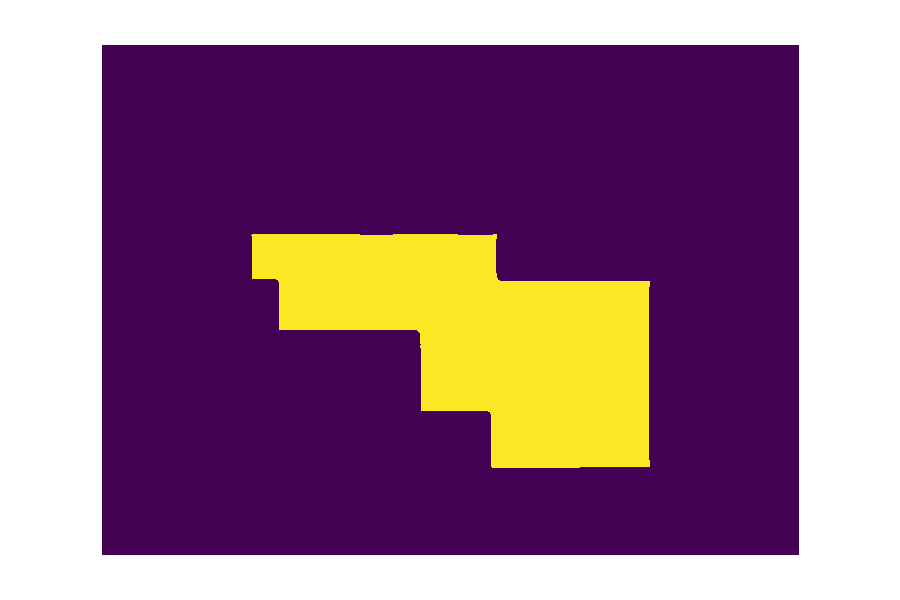

In [27]:
unit_dict, unit_comb = get_unit_mask(bgr)
fig = plt.figure(figsize=(3, 2), dpi=300)
plt.axes().axis('off')
plt.imshow(unit_dict["LDK"])
plt.tight_layout()
# fig.savefig(".pdf")

# main

In [5]:
dir_ID_from = "/fp_img/"
exp_ID_from = dir_ID_from

parent_dir = "/data/"

dir_IDs_exclude = "exclude/"

dir_from = "/fp_img/"
exp_dir_from = dir_from

dir_to = "fp_img_processed/"
exp_dir_to = expanduser(parent_dir + dir_to)
ext_to = ".png"

path_fp = "floorplans.csv"
exp_path_fp = expanduser(parent_dir + path_fp)

path_fp_img = "fp_img.csv"
exp_path_fp_img = expanduser(parent_dir + path_fp_img)


### all of the plans
IDs = [splitext(f.name)[0] for f in scandir(exp_ID_from) if f.is_file()]
print(len(IDs), "floorplans")


files_IDs_exclude = list(Path(expanduser(parent_dir + dir_IDs_exclude)).glob("*.csv"))

IDs_excl = set()
for file_excl in files_IDs_exclude:
    _, file_excl_list = read_from_csv(str(file_excl))
    if file_excl_list:
        list_excl = [row[0] for row in file_excl_list]
    IDs_excl |= set(list_excl)
    print(file_excl, "processed:", len(list_excl), "floorplans to exclude")

_, fp_img_processed_list = read_from_csv(exp_path_fp_img)
if fp_img_processed_list:
    list_excl = [row[0] for row in fp_img_processed_list]
    IDs_excl |= set(list_excl)
    print(len(list_excl), "floorplans already processed")

# print(IDs_excl)

IDs = list(set(IDs).difference(IDs_excl))
print(len(IDs), "floorplans to go")


ext_from_dict = {
    splitext(f.name)[0]: splitext(f.name)[1]
    for f in scandir(exp_ID_from)
    if f.is_file()
}


# _, fp_list = read_from_csv(exp_path_fp)
# bedroom_dict = {i[0]+'_'+i[1]: int(i[4]) for i in fp_list} # {ID: N of bedrooms}

paths_from = {ID: exp_dir_from + ID + ext_from_dict[ID] for ID in IDs}
paths_to = {ID: exp_dir_to + ID + ext_to for ID in IDs}

makedirs(exp_dir_to, exist_ok=True)


def process_image(path_from, path_to, ext_to=".png"):
    # print(ID)

    bgr = read_bgr_from_image_unicode(path_from)

    ### get mask

    unit_dict, unit_comb = get_unit_mask(bgr)

    mask_bgr = np.zeros_like(bgr)

    mask_bgr |= unit_comb[:, :, None]

    save_bgr_to_image_unicode(mask_bgr, path_to, ext_to)


### create csv file to save completed list
if not Path(exp_path_fp_img).parent.exists():
    Path(exp_path_fp_img).parent.mkdir()

if not Path(exp_path_fp_img).is_file():
    with open(exp_path_fp_img, "w", newline="", encoding="utf-8-sig") as csvfile:
        listwriter = csv.writer(csvfile)
        listwriter.writerow(["ID", "Path"])

with open(exp_path_fp_img, "a", newline="", encoding="utf-8-sig") as csvfile:
    listwriter = csv.writer(csvfile)

    ########################################################################
    #
    # [process_image(paths_from[ID], paths_to[ID], ext_to) for ID in IDs]

    IDs_error = []
    for ID in tqdm_notebook(IDs, desc="Processing plans"):
        process_image(paths_from[ID], paths_to[ID], ext_to)
        try:
            listwriter.writerow([ID, paths_to[ID]])
        except:
            IDs_error.append(ID)
    print(len(IDs_error))
    print(IDs_error)

51551 floorplans
/data/exclude/fp_img_multi-level.csv processed: 861 floorplans to exclude
/data/exclude/fp_img_multi-unit.csv processed: 15 floorplans to exclude
/data/exclude/fp_img_exclude.csv processed: 861 floorplans to exclude
50604 floorplans already processed
0 floorplans to go



0
[]
